Exlporing  and Comapring different Machine Learning Algotihms to predict Visitors who are likely to cancel their booking. 

Contributors: Divyanshu Kumar

In [54]:
# Importing Neccessary Libraries
import numpy as np
import pandas as pd
#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#For ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [55]:
#Importing the dataset
hotels = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv')

### Basic Exploratory Data Analysis

In [56]:
#Checking the Shape of the Dataset
print("Row count {} Column Count {}".format(hotels.shape[0],hotels.shape[1]))

Row count 119390 Column Count 32


In [57]:
#checking Variable wise Null Count
for i in range(hotels.shape[1]):
  print("Null vlaue count for Variable {} is {}".format(hotels.columns[i],hotels.iloc[:,i].isnull().sum()))

Null vlaue count for Variable hotel is 0
Null vlaue count for Variable is_canceled is 0
Null vlaue count for Variable lead_time is 0
Null vlaue count for Variable arrival_date_year is 0
Null vlaue count for Variable arrival_date_month is 0
Null vlaue count for Variable arrival_date_week_number is 0
Null vlaue count for Variable arrival_date_day_of_month is 0
Null vlaue count for Variable stays_in_weekend_nights is 0
Null vlaue count for Variable stays_in_week_nights is 0
Null vlaue count for Variable adults is 0
Null vlaue count for Variable children is 4
Null vlaue count for Variable babies is 0
Null vlaue count for Variable meal is 0
Null vlaue count for Variable country is 488
Null vlaue count for Variable market_segment is 0
Null vlaue count for Variable distribution_channel is 0
Null vlaue count for Variable is_repeated_guest is 0
Null vlaue count for Variable previous_cancellations is 0
Null vlaue count for Variable previous_bookings_not_canceled is 0
Null vlaue count for Variabl

The dataset is relatively clean with just one variable named children having null values. It would be replaced by the mode as mean could given us a non-interger value and No. of children must be a discrete value. 

In [58]:
#Imputing Data
import statistics
hotels["children"].fillna(statistics.mode(hotels['children']), inplace = True)

In [59]:
print("Null values for children column",hotels['children'].isnull().sum())

Null values for children column 0


We would have to remove agent and comapny coulmn as they have too many NA values.

In [60]:
hotels.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Using describe() will summary statistics of all numerical columns. We will take this list of columns to create a new dataset. We do this because for our classification task, Algos like SVM won't work with numerical values.

In [61]:
hotels.describe().columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

In [62]:
#New dataset with only numerical columns
hotels_one = hotels[hotels.describe().columns]

We would need to drop variables agent and comapany because they have a lot of NA values.

In [63]:
hotels_one = hotels_one[hotels_one.columns.difference(['agent','company'])]

In [64]:
hotels_one.shape

(119390, 18)

In [65]:
hotels_one.describe()

,adr,adults,arrival_date_day_of_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,days_in_waiting_list,is_canceled,is_repeated_guest,lead_time,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,101.831122,1.856403,15.798241,27.165173,2016.156554,0.007949,0.221124,0.103886,2.321149,0.370416,0.031912,104.011416,0.137097,0.087118,0.062518,2.500302,0.927599,0.571363
std,50.535790,0.579261,8.780829,13.605138,0.707476,0.097436,0.652306,0.398555,17.594721,0.482918,0.175767,106.863097,1.497437,0.844336,0.245291,1.908286,0.998613,0.792798
min,-6.380000,0.000000,1.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.290000,2.000000,8.000000,16.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,94.575000,2.000000,16.000000,28.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
75%,126.000000,2.000000,23.000000,38.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,160.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000
max,5400.000000,55.000000,31.000000,53.000000,2017.000000,10.000000,21.000000,10.000000,391.000000,1.000000,1.000000,737.000000,72.000000,26.000000,8.000000,50.000000,19.000000,5.000000


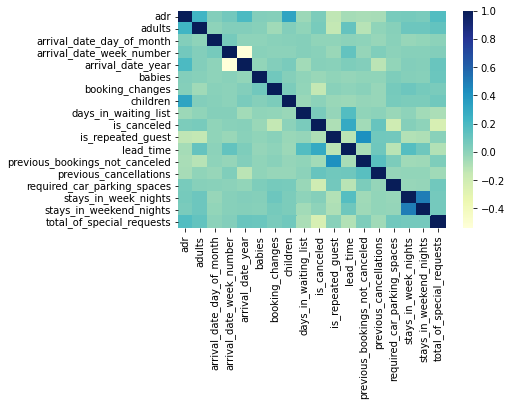

In [66]:
#exploring the correlation matrix and variance for each variable to get rid of reduntant features
cor_mat = hotels_one.corr()
sns.heatmap(cor_mat, cmap="YlGnBu")
plt.show()

Correlation among different variable seems to be below one.

In [67]:
#checking whether any variable has variance = 0. It can also be done by looking at summary statistics.
for i in range(hotels_one.shape[1]):
  if hotels_one.iloc[:,i].var() == 0:
    print("{} has Variance 0".format(hotels_one.columns[i]))


No output means no value is equal to 0.

Our target Variable is the is_cancelled column. Let's explore it

In [68]:
hotels['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

About One-third of the bookings have been cancelled.

Model Analysis: Initiating a table that will have the output of multiple Classification models.



In [69]:
Model_results = pd.DataFrame(columns = ["Model", "Test accuracy"])

###Classification: 

The aim of this analysis is to train different models and analyse which model does the best when it comes to predicting which visitors would cancel their hotel bookings.

In [70]:
# Preparing the Dataset
X,y = train_test_split(hotels_one,test_size= 0.2)

In [71]:
print("Shape of X",X.shape)
print("Shape of y",y.shape)

Shape of X (95512, 18)
Shape of y (23878, 18)


Splitting further into X_train,y_train,X_test and y_test

In [72]:
y_train = X['is_canceled']
X_train = X[X.columns.difference(['is_canceled'])]

In [73]:
y_test = y['is_canceled']
X_test = y[y.columns.difference(['is_canceled'])]

We now have seperated the labels from the dataset.

#### First Model: Decision Trees 

Utilizing Grid Search to find the optimal parameters.

In [74]:
#for scaling Data
std_slc = StandardScaler()
#Intializing Model
dec_tree = DecisionTreeClassifier()
#Create pipeline
pipe = Pipeline(steps=[('std_slc', std_slc),
                      ('dec_tree', dec_tree)])
#set parameters
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': [2, 4, 6, 8, 10, 12]})

In [75]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])

Best Criterion: gini
Best max_depth: 12


So we will use these parameters to predict on X_test and get our accuracy score.

In [76]:
dec_tree_best = DecisionTreeClassifier(criterion='gini',max_depth=12)
std_slc.fit_transform(X_train,X_test)
dec_tree_best.fit(X_train,y_train)
pred = dec_tree_best.predict(X_test)
acc = accuracy_score(pred,y_test)
print(acc)

0.783859619733646


In [77]:
Model_results = Model_results.append({"Model": "Decision Tree", "Test accuracy":acc},ignore_index=True)

In [78]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.78386


###Support Vector Machines

One of the key advantages of SVM is that it can work with Fewer datapoints. So we will subset 10000 datapoints.

In [79]:
X_train_sub = X_train.iloc[:10000,:]
y_train_sub = y_train.iloc[:10000]

We are going to try three different models:
* Linear

* Ploynomial
* Radial Basis Kernel



####Linear

In [80]:
lin_svm = SVC(kernel= 'linear',C = 0.5)
lin_svm.fit(X_train_sub,y_train_sub)

SVC(C=0.5, kernel='linear')

In [81]:
pred = lin_svm.predict(X_test)
acc = accuracy_score(pred,y_test)
print(acc)

0.7274059804003685


In [82]:
Model_results = Model_results.append({"Model": "SVM Linear : 0.5", "Test accuracy":acc},ignore_index=True)

We wil try 2 more models with different values of C.

In [83]:
C_list = [0.1,1]
for i in range(2):
  lin_svm = SVC(kernel= 'linear',C = C_list[i])
  lin_svm.fit(X_train_sub,y_train_sub)
  pred = lin_svm.predict(X_test)
  acc = accuracy_score(pred,y_test)
  Model_results = Model_results.append({"Model": "SVM Linear : {}".format(C_list[i]), "Test accuracy":acc},ignore_index=True)

In [84]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580


We'll now try Polynomial SVM with different C values and different degrees

In [85]:
D_list = [2,3,4]
for i in range(3):
  poly_svm = SVC(kernel= 'poly',C = 1,degree = D_list[i])
  poly_svm.fit(X_train_sub,y_train_sub)
  pred = poly_svm.predict(X_test)
  acc = accuracy_score(pred,y_test)
  Model_results = Model_results.append({"Model": "SVM Polynomial : {}".format(D_list[i]), "Test accuracy":acc},ignore_index=True)

In [86]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580
4,SVM Polynomial : 2,0.663205
5,SVM Polynomial : 3,0.664084
6,SVM Polynomial : 4,0.658472


Using different Degrees for Polynomial regression doesn't seem to help much.

Now we will try different models with rbf kernel.

In [87]:
gamma_list = [0.01,0.1,1]
for i in range(3):
  rbf_svm = SVC(kernel= 'rbf',C = 1,gamma = gamma_list[i])
  rbf_svm.fit(X_train_sub,y_train_sub)
  pred = rbf_svm.predict(X_test)
  acc = accuracy_score(pred,y_test)
  Model_results = Model_results.append({"Model": "SVM Rbf with gamma: {}".format(gamma_list[i]), "Test accuracy":acc},ignore_index=True)

In [88]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580
4,SVM Polynomial : 2,0.663205
5,SVM Polynomial : 3,0.664084
6,SVM Polynomial : 4,0.658472
7,SVM Rbf with gamma: 0.01,0.724768
8,SVM Rbf with gamma: 0.1,0.754795
9,SVM Rbf with gamma: 1,0.755423


When it comes to SVM, Linear model with C = 0.5 looks to be doing the best. 

###Logistic Regression

For Logistic Regression we will search through different solvers, C value and use l2 penalty.

In [ ]:
C_Values = [1,10,0.1]
for i in range(len(C_Values)):
  Log_reg = LogisticRegression(penalty='l2',solver='lbfgs')
  Log_reg.fit(X_train,y_train)
  pred = Log_reg.predict(X_test)
  acc = accuracy_score(pred,y_test)
  Model_results = Model_results.append({"Model": "L2 Logistic regression  with C: {}".format(C_Values[i]), "Test accuracy":acc},ignore_index=True)

In [90]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580
4,SVM Polynomial : 2,0.663205
5,SVM Polynomial : 3,0.664084
6,SVM Polynomial : 4,0.658472
7,SVM Rbf with gamma: 0.01,0.724768
8,SVM Rbf with gamma: 0.1,0.754795
9,SVM Rbf with gamma: 1,0.755423


###Naive Bayes 

In [91]:
#Intializing the Model
gnb = GaussianNB()
#Fitting the model
gnb.fit(X_train,y_train)
#Predicting
pred = gnb.predict(X_test)
#COmputing accuracy
acc = accuracy_score(pred,y_test)
#Appending results in the table
Model_results = Model_results.append({"Model": "Gaussian NB", "Test accuracy":acc},ignore_index=True)

In [92]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580
4,SVM Polynomial : 2,0.663205
5,SVM Polynomial : 3,0.664084
6,SVM Polynomial : 4,0.658472
7,SVM Rbf with gamma: 0.01,0.724768
8,SVM Rbf with gamma: 0.1,0.754795
9,SVM Rbf with gamma: 1,0.755423


As observed Gaussian NB should not be used in this case as it has very low accuracy.

###Bagging: Random Forest 

In [93]:
max_depth=[2, 8, 16]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the grid search
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid,cv=5)
grid_results = grid.fit(X_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.67697256 0.67740183 0.67740183 0.77059431 0.77165177 0.77165181
 0.81700734 0.8169131  0.81780305], using {'max_depth': 16, 'n_estimators': 256}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.381520,0.051913,0.073003,0.000360,2,64,"{'max_depth': 2, 'n_estimators': 64}",0.675287,0.675653,0.680348,0.675636,0.677939,0.676973,0.001934,9
1,2.702282,0.026807,0.143156,0.002421,2,128,"{'max_depth': 2, 'n_estimators': 128}",0.675496,0.675915,0.679981,0.677730,0.677887,0.677402,0.001602,8
2,5.376943,0.040858,0.281338,0.005236,2,256,"{'max_depth': 2, 'n_estimators': 256}",0.675705,0.675548,0.679615,0.677887,0.678254,0.677402,0.001560,7
3,3.126377,0.048509,0.121690,0.002565,8,64,"{'max_depth': 8, 'n_estimators': 64}",0.773177,0.764330,0.777144,0.773950,0.764370,0.770594,0.005269,6
4,6.194833,0.058577,0.236035,0.003875,8,128,"{'max_depth': 8, 'n_estimators': 128}",0.771711,0.767523,0.776830,0.774788,0.767407,0.771652,0.003787,5
5,12.454291,0.076485,0.463324,0.004585,8,256,"{'max_depth': 8, 'n_estimators': 256}",0.769931,0.765534,0.777667,0.776830,0.768297,0.771652,0.004788,4
6,5.076640,0.030125,0.227657,0.003381,16,64,"{'max_depth': 16, 'n_estimators': 64}",0.814113,0.814846,0.823317,0.821432,0.811329,0.817007,0.004576,2
7,10.149092,0.043781,0.453275,0.005831,16,128,"{'max_depth': 16, 'n_estimators': 128}",0.814741,0.814636,0.823736,0.819443,0.812009,0.816913,0.004169,3
8,20.339731,0.134943,0.897275,0.006055,16,256,"{'max_depth': 16, 'n_estimators': 256}",0.816259,0.814793,0.824312,0.820542,0.813109,0.817803,0.004083,1


From the data i can be observed the best optimal value of hyperparameters the search gives is:

1.   max_depth: 16
2.   n_estimators: 256



In [94]:
random_forest_final = RandomForestClassifier(max_depth=16,n_estimators=256)
random_forest_final.fit(X_train,y_train)
pred = random_forest_final.predict(X_test)
acc = accuracy_score(pred,y_test)
Model_results = Model_results.append({"Model": "Random Forest", "Test accuracy":acc},ignore_index=True)


In [96]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580
4,SVM Polynomial : 2,0.663205
5,SVM Polynomial : 3,0.664084
6,SVM Polynomial : 4,0.658472
7,SVM Rbf with gamma: 0.01,0.724768
8,SVM Rbf with gamma: 0.1,0.754795
9,SVM Rbf with gamma: 1,0.755423


The random forest model is one of the best performing model thus far. Let's see how XGBoost and Neural Networks work.

###Boosting: XGBoost

Since XBBoost is know to be the champion of algorithms we will not hypertune it to find the best,rather we will us the base model.

In [97]:
from xgboost import XGBClassifier
xg_model = XGBClassifier()
xg_model.fit(X_train,y_train)
pred = xg_model.predict(X_test)
acc = accuracy_score(pred,y_test)

In [98]:
acc

0.7735153697964654

In [99]:
max_depth=[2, 8, 16,32]
n_estimators = [5,10,15,20]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the grid search
xg_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=xg_model, param_grid=param_grid,cv=2)
grid_results = grid.fit(X_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.69760868 0.74803166 0.74557124 0.74558171 0.76835371 0.7703744
 0.77808024 0.7794518  0.80636988 0.81233772 0.81624299 0.81826367
 0.81184563 0.81779253 0.82050423 0.82336251], using {'max_depth': 32, 'n_estimators': 20}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.192870,0.001810,0.029695,0.000761,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.677506,0.717711,0.697609,0.020102,16
1,0.310358,0.000437,0.034475,0.000212,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.747403,0.748660,0.748032,0.000628,13
2,0.409530,0.005033,0.040145,0.000089,2,15,"{'max_depth': 2, 'n_estimators': 15}",0.747424,0.743718,0.745571,0.001853,15
3,0.513284,0.008655,0.044579,0.000173,2,20,"{'max_depth': 2, 'n_estimators': 20}",0.747424,0.743739,0.745582,0.001843,14
4,0.493396,0.009836,0.038897,0.000427,8,5,"{'max_depth': 8, 'n_estimators': 5}",0.766249,0.770458,0.768354,0.002104,12
5,0.915966,0.008627,0.053396,0.000456,8,10,"{'max_depth': 8, 'n_estimators': 10}",0.767150,0.773599,0.770374,0.003225,11
6,1.327037,0.024389,0.069708,0.000425,8,15,"{'max_depth': 8, 'n_estimators': 15}",0.777410,0.778750,0.778080,0.000670,10
7,1.726243,0.036181,0.085655,0.000676,8,20,"{'max_depth': 8, 'n_estimators': 20}",0.777452,0.781452,0.779452,0.002000,9
8,1.124585,0.006908,0.056216,0.000288,16,5,"{'max_depth': 16, 'n_estimators': 5}",0.806244,0.806496,0.806370,0.000126,8
9,2.183312,0.010533,0.096120,0.001079,16,10,"{'max_depth': 16, 'n_estimators': 10}",0.812819,0.811856,0.812338,0.000482,6


In [100]:
from xgboost import XGBClassifier
xg_model = XGBClassifier(max_depth=32,n_estimators=20)
xg_model.fit(X_train,y_train)
pred = xg_model.predict(X_test)
acc = accuracy_score(pred,y_test)

In [102]:
#Updating results for final mode;
Model_results = Model_results.append({"Model": "XGboost", "Test accuracy":acc},ignore_index=True)

Analyzing the final table.

In [103]:
Model_results

,Model,Test accuracy
0,Decision Tree,0.783860
1,SVM Linear : 0.5,0.727406
2,SVM Linear : 0.1,0.725438
3,SVM Linear : 1,0.720580
4,SVM Polynomial : 2,0.663205
5,SVM Polynomial : 3,0.664084
6,SVM Polynomial : 4,0.658472
7,SVM Rbf with gamma: 0.01,0.724768
8,SVM Rbf with gamma: 0.1,0.754795
9,SVM Rbf with gamma: 1,0.755423


No Surprises here, XGboost turned out to be the best performing Model.